# Test case C: Learning the layout from the criterion evaluation for each row

In [1]:
import jax
import jax.numpy as jnp
from hybridoed.oed import *
import numpy as np
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [2]:
#TODO: fo a given Jacobian, evaluate the nRER for each block corresponding to a source

# load the jacobians
jacobians = jnp.load("curvel_jac_5_5_5.npy")

In [3]:
print(jacobians.shape)

transposed_jacobians = jnp.transpose(jacobians, axes=(1, 2, 0, 3))

print(transposed_jacobians.shape)


(5, 25, 25, 9800)
(25, 25, 5, 9800)


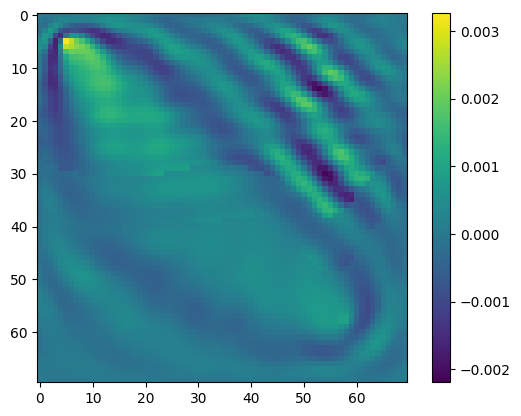

In [4]:
# plot the jacobians
plt.figure()
plt.imshow(jacobians[-1,0,-1,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

In [5]:
stacked_array = jnp.stack([array.reshape(-1, array.shape[-1]) for array in transposed_jacobians])
stacked_array.shape

(25, 125, 9800)

In [6]:
complex_stack_complete = []
for src in stacked_array:
    complex_stack = []
    for row in src:
        real_part = row.reshape(70,140)[:,:70]
        imaginary_part = row.reshape(70,140)[:,70:]
        complex_stack.append(real_part + 1j * imaginary_part)

    # Convert to NumPy array if needed
    complex_stack = jnp.array(complex_stack)

    print(complex_stack.shape)

    # Flatten all rows into num_rows x 4900 matrix
    num_rows = complex_stack.shape[0]
    complex_reshaped = np.empty((num_rows, 4900), dtype=np.complex128)

    for i, complex_matrix in enumerate(complex_stack):
        complex_reshaped[i, :] = complex_matrix.flatten()
    
    complex_stack_complete.append(complex_reshaped)

complex_stack_complete = jnp.array(complex_stack_complete)
print(complex_stack_complete.shape)

complex_stack_complete_2D = jnp.vstack([array for array in complex_stack_complete])
print(complex_stack_complete_2D.shape)


(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(25, 125, 4900)
(3125, 4900)


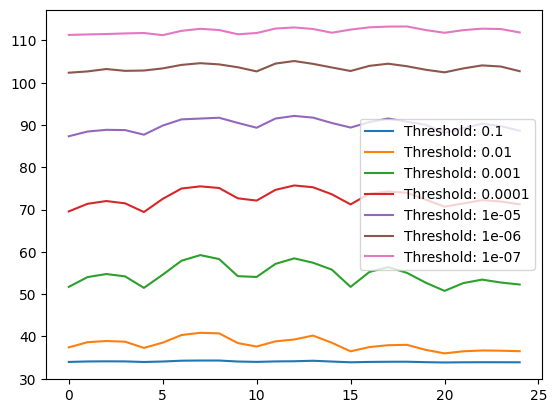

In [7]:
plt.figure()

threshold = [1e-1, 1e-2,1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
for th in threshold:
    C_sources = []
    for array in stacked_array:
        C_sources.append(eigenvalue_criterion(array, threshold=th))
    plt.plot(C_sources, label=f"Threshold: {th}")


plt.legend()
plt.show()

criterion_threshold = 1e-2

C_sources_1e_3 = [] 
for array in stacked_array:
    C_sources_1e_3.append(eigenvalue_criterion(array, threshold=criterion_threshold))

C_sources_1e_3 = jnp.array(C_sources_1e_3)

In [8]:
# Compute the singular values of the Jacobian and plot them
singular_values = jnp.sort(jnp.linalg.svdvals(complex_stack_complete_2D)**2)[::-1]



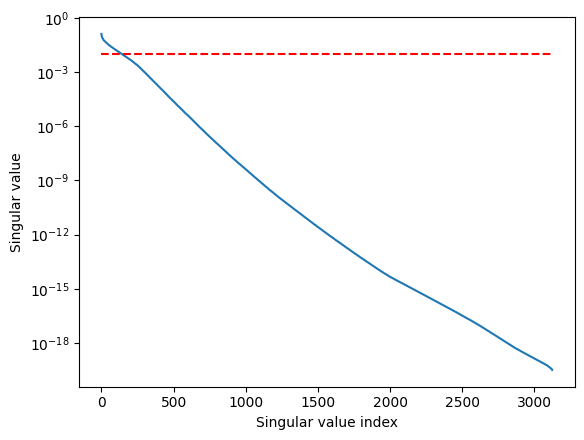

In [9]:
plt.figure()
# plt.plot(singular_values)
plt.semilogy(singular_values)
# plt.yscale('log')
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.hlines(criterion_threshold, 0, len(singular_values), colors='r', linestyles='dashed', label='Threshold')

plt.show()


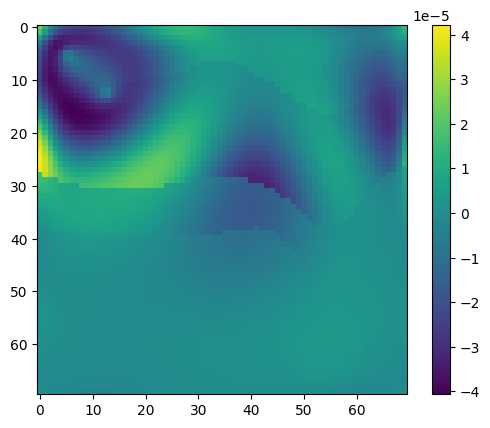

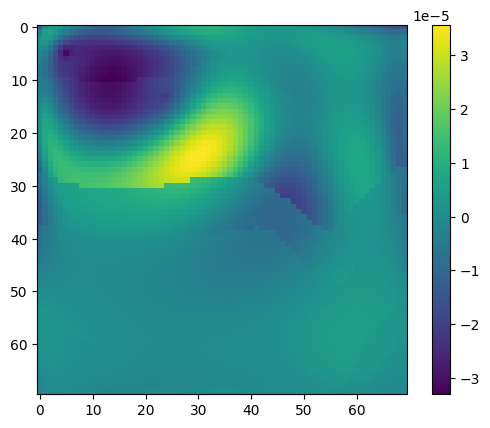

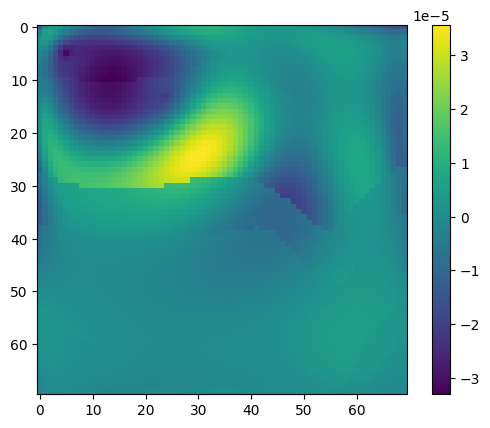

In [10]:
# plot the stacked array
plt.figure()
plt.imshow(stacked_array[0,0,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(stacked_array[0,5,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(jnp.real(complex_stack_complete[0,5,:].reshape(70,70)), cmap='viridis')
plt.colorbar()
plt.show()

In [11]:
# Fully Connected Neural Network
class FullyConnectedNN(eqx.Module):
    layers: list
    activations: list

    def __init__(self, input_size, hidden_size, num_hidden_layers, key):
        keys = jax.random.split(key, num_hidden_layers + 1)
        self.layers = [eqx.nn.Linear(input_size, hidden_size, key=keys[0])] + \
                      [eqx.nn.Linear(hidden_size, hidden_size, key=k) for k in keys[1:-1]] + \
                      [eqx.nn.Linear(hidden_size, input_size, key=keys[-1])]
        
        self.activations = [jax.nn.tanh] * num_hidden_layers + [jax.nn.sigmoid]

    def __call__(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        return x

# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

# Differentiable Loss Function
def differentiable_loss_fn(model, x, matrix, criterion_threshold ,sharpness=10.0, mask_penalty=0.1):
    probabilities = model(x)  # Predict probabilities
    soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    
    

    multiplier = matrix.shape[0] // soft_mask.shape[0]
    soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows
    # singular_values = jnp.linalg.svd(weighted_matrix, compute_uv=False)  # SVD
    # singular_loss = -jnp.sum(singular_values)  # Maximize singular values
    regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask
    norm_loss = jnp.linalg.norm(soft_mask, ord=1)

    singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)

    return -(singular_loss) + regularization_loss + 0.1*norm_loss



In [12]:
# Example Usage
key = jax.random.PRNGKey(42)
input_size = C_sources_1e_3.shape[0]
hidden_size = 56
num_hidden_layers = 2
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)

print("Model:", model)

# matrix = jax.random.normal(key, (100, 50))  # Matrix with 100 rows and 50 columns
matrix = complex_stack_complete_2D
# x = jax.random.normal(key, (input_size,))  # Input to the network
x = C_sources_1e_3
# x = (x - jnp.mean(x)) / jnp.std(x)
x = (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))




Model: FullyConnectedNN(
  layers=[
    Linear(
      weight=f32[56,25],
      bias=f32[56],
      in_features=25,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[25,56],
      bias=f32[25],
      in_features=56,
      out_features=25,
      use_bias=True
    )
  ],
  activations=[
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function sigmoid>
  ]
)


In [13]:
# loss = differentiable_loss_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)
# print("Loss:", loss)

# # Compute Gradients
# # grads = jax.grad(differentiable_loss_fn)(model, x, matrix, sharpness=10.0, mask_penalty=0.1)

# # Compute Gradients using equinox.filter_grad
# # grad_fn = eqx.filter_grad(differentiable_loss_fn)
# # grads = grad_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)

# loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
# loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)
# print("Loss:", loss)

Gradient shape: (56, 25) Gradient values: [[ 0.22093172  0.4118971   0.45506933 ...  0.10689675  0.09867369
   0.08050337]
 [-0.00568917 -0.01060667 -0.01171839 ... -0.00275268 -0.00254092
  -0.00207303]
 [-0.14076148 -0.26243058 -0.28993678 ... -0.06810676 -0.06286763
  -0.05129084]
 ...
 [-0.17304699 -0.32262254 -0.35643762 ... -0.08372795 -0.07728715
  -0.06305508]
 [ 0.6388268   1.1910055   1.3158386  ...  0.30909324  0.28531617
   0.2327765 ]
 [-0.29689518 -0.5535206  -0.61153686 ... -0.14365129 -0.13260087
  -0.10818303]]
Gradient shape: (56,) Gradient values: [ 0.7563828  -0.01947745 -0.4819116   0.4898879  -0.07999161 -1.1741576
  1.3283935  -0.6683498   0.12291282  1.4326448   1.0221568  -0.56025356
  0.5653834  -0.77783746 -1.6957293  -0.06175292 -0.3659726  -1.6419854
  0.3851881   0.6567956   0.15575628 -0.68805563  0.48281097  0.5518607
  0.47384295 -0.7043563  -0.25445178 -1.5606713   0.13627334 -0.33767805
 -0.00745904  0.08706316  0.43817505  0.67825437 -0.9742614   0.8

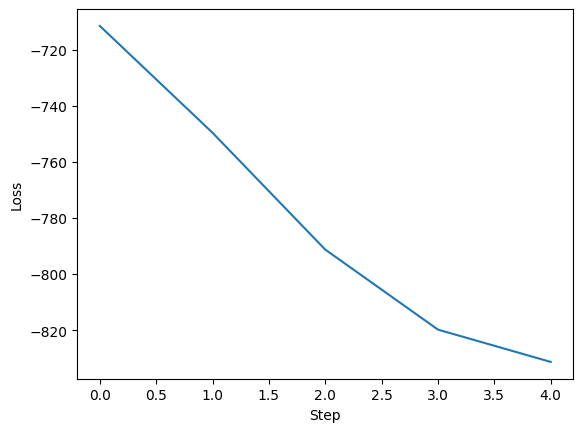

In [14]:
def train_step(model, matrix, criterion_threshold, optimizer, opt_state, x, logs):
    # Compute loss and gradients
    loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
    loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=criterion_threshold, sharpness=10.0, mask_penalty=10.0)
    jax.tree_util.tree_map(lambda g: print("Gradient shape:", g.shape, "Gradient values:", g), grads)
    jax.tree_util.tree_map(lambda g: print(f"Gradient shape: {g.shape}, Min: {jnp.min(g)}, Max: {jnp.max(g)}, Mean: {jnp.mean(g)}"), grads)

    # Update optimizer state and model
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)

    # Log the network output (predicted probabilities)
    probabilities = model(x)  # Network output
    logs["probabilities"].append(probabilities)

    # Log the mask M
    soft_mask = differentiable_mask(probabilities, sharpness=10.0)  # Differentiable mask
    logs["masks"].append(soft_mask)

    return loss, model, opt_state

# def train_step(model, matrix, criterion_threshold, optimizer, opt_state, x):
#     loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
#     loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=criterion_threshold, sharpness=10.0, mask_penalty=0.1)
#     # print("Gradients:", grads)
#     # print("Max Gradient:", jax.tree_util.tree_reduce(lambda x, y: jnp.maximum(x, y), grads))
#     # print("Min Gradient:", jax.tree_util.tree_reduce(lambda x, y: jnp.minimum(x, y), grads))
#     jax.tree_util.tree_map(lambda g: print("Gradient shape:", g.shape, "Gradient values:", g), grads)
#     jax.tree_util.tree_map(lambda g: print(f"Gradient shape: {g.shape}, Min: {jnp.min(g)}, Max: {jnp.max(g)}, Mean: {jnp.mean(g)}"), grads)


#     updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
#     model = eqx.apply_updates(model, updates)
#     return loss, model, opt_state

# Initialize the model and optimizer
key = jax.random.PRNGKey(42)
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)
optimizer = optax.adamw(1e-2)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))  # Initialize optimizer state

# Training loop
num_steps = 5
losses = []
logs = {"probabilities": [], "masks": []}
for step in range(num_steps):
    loss, model, opt_state = train_step(model, matrix, criterion_threshold, optimizer, opt_state, x, logs)
    losses.append(loss)

    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()


Step 0: Probabilities: [0.5092358  0.35794908 0.4950742  0.35527164 0.4166689  0.39456204
 0.45434824 0.46048686 0.45079026 0.44038108 0.41273174 0.40628776
 0.49750707 0.44103354 0.37950507 0.42288622 0.4343158  0.34903342
 0.4451899  0.380631   0.44143578 0.37660947 0.49278802 0.41992164
 0.37123588]
Step 0: Mask: [0.5230731  0.19458176 0.487688   0.19041996 0.3029454  0.25838497
 0.38781226 0.40248263 0.37939957 0.35521603 0.2946964  0.28148198
 0.49376795 0.35671183 0.23059592 0.31623304 0.34144938 0.18098831
 0.3663051  0.2325996  0.35763538 0.22549863 0.48197782 0.3098579
 0.21625231]
Step 1: Probabilities: [0.4420734  0.23689502 0.40099972 0.2681371  0.3156122  0.2933223
 0.3628226  0.34712994 0.37908506 0.3424451  0.32489228 0.30059367
 0.44228932 0.33501017 0.29225624 0.3028831  0.31830868 0.24051645
 0.35837144 0.27946025 0.34182453 0.2642823  0.40545252 0.32135287
 0.27920383]
Step 1: Mask: [0.35910153 0.06716666 0.27091154 0.08959182 0.13659328 0.11236811
 0.20233338 0.1781

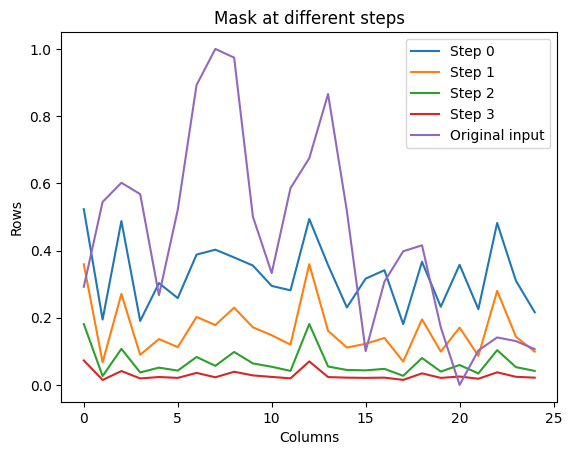

In [15]:
# Print the first few steps for inspection
for i, (probs, mask) in enumerate(zip(logs["probabilities"], logs["masks"])):
    print(f"Step {i}: Probabilities: {probs}")
    print(f"Step {i}: Mask: {mask}")
    if i > 5:  # Limit to first few steps for readability
        break

# Example: Plot the first mask at different training steps
steps_to_plot = [0, 1, 2, 3]  # Select steps to visualize
plt.figure()

for step in steps_to_plot:
    plt.title(f"Mask at different steps")
    plt.plot(logs["masks"][step], label=f"Step {step}")
    # plt.colorbar(label="Mask Values")
    plt.xlabel("Columns")
    plt.ylabel("Rows")

plt.plot(x, label="Original input")
plt.legend()
plt.show()